In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

VIDEO_PATH = './VID_20230515_105413.mp4'
DOWNSCALE_FACTOR = 80 # percent of original size
FRAMES_PER_TIME_WINDOW = 15
TIME_PER_FRAME = 1/60 # seconds
PIXEL_TO_METER_RATIO = 1 # m/pixel
CAMERA_DIMENSIONS = (1080, 1920) # (height, width)
FOOSBALL_WIDTH = 0.7 # meters

In [2]:
video = cv2.VideoCapture(VIDEO_PATH)

(1080, 1920, 3)
((988.6245727539062, 498.0497131347656), (1595.040283203125, 931.140625), 0.9130027890205383)


/var/folders/25/74rk2vkj73b0yxyz96k8dfkc0000gp/T/ipykernel_42508/3118818143.py:32: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


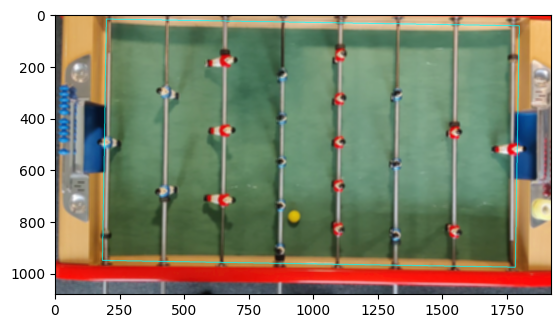

In [7]:
video.set(cv2.CAP_PROP_POS_FRAMES, 12000)
ret, frame = video.read()
print(frame.shape)
mask_field_low = (33, 20, 0)
mask_field_high = (92, 255, 255)


frame = cv2.blur(frame, (10, 10))

frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

mask = cv2.inRange(frame, mask_field_low, mask_field_high)

mask = cv2.erode(mask, np.ones((8, 8), np.uint8), iterations=2)

mask = cv2.dilate(mask, np.ones((10, 10), np.uint8), iterations=6)

contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
biggest_area = 0

for cnt in contours:
   area = cv2.contourArea(cnt)
   if area > biggest_area:
      biggest_area = area
      biggest_contour = cnt



frame = cv2.cvtColor(frame, cv2.COLOR_HSV2RGB)
rect = cv2.minAreaRect(biggest_contour)
box = cv2.boxPoints(rect)
box = np.int0(box)
img = cv2.drawContours(frame,[box],0,(0,255,255),2)
print(rect)
foosball_width_px = rect[1][1]
PIXEL_TO_METER_RATIO = FOOSBALL_WIDTH / foosball_width_px

# x1,y1 = biggest_contour[0][0]
# approx = cv2.approxPolyDP(biggest_contour, 0.01*cv2.arcLength(biggest_contour, True), True)
# if len(approx) == 4:
#    x, y, w, h = cv2.boundingRect(biggest_contour)
#    print(x, y, w, h)
#    ratio = float(w)/h
   
#    if ratio >= 0.9 and ratio <= 1.1:
#       print('a')
#       img = cv2.drawContours(frame, [biggest_contour], -1, (0,255,255), 3)
#       cv2.putText(frame, 'Square', (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)
#    else:
#       print('b')

#       cv2.putText(frame, 'Rectangle', (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
#       frame = cv2.drawContours(frame, [biggest_contour], -1, (0,255,0), 3)


plt.imshow(img)

In [3]:
def get_biggest_contour_center(frame):
    biggest_area = 0
    biggest_contour = None
    contours, _ = cv2.findContours(frame, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > biggest_area:
            biggest_area = area
            biggest_contour = cnt

    if biggest_contour is None:
        return None
    
    M = cv2.moments(biggest_contour)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    return cX, cY


def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]

def get_pixel_to_meter_ratio(frame, mask_field_low, mask_field_high):

    mask = get_mask(frame, mask_field_low, mask_field_high)

    mask = cv2.dilate(mask, np.ones((10, 10), np.uint8), iterations=6)

    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #We get the biggest countour we find, should be the field
    biggest_area = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > biggest_area:
            biggest_area = area
            biggest_contour = cnt


    frame = cv2.cvtColor(frame, cv2.COLOR_HSV2RGB)
    rect = cv2.minAreaRect(biggest_contour)
    foosball_width_px = rect[1][1]
    pixel_to_meter_ratio = FOOSBALL_WIDTH / foosball_width_px

    return pixel_to_meter_ratio
    
def get_goals(frame, mask_goals_low, mask_goals_high):
    mask_goals = get_mask(frame, mask_goals_low, mask_goals_high)
    contours, _ = cv2.findContours(mask_goals, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    goals = []

    # Get the biggest 2 contours, should be the goals    
    contours.sort(contours, key= cv2.contourArea)
    goal1, goal2 = cv2.minAreaRect(contours[-1]), cv2.minAreaRect(contours[-2])


        



def get_mask(frame, mask_range_low, mask_range_high):
    width = int(frame.shape[1] * DOWNSCALE_FACTOR / 100)
    height = int(frame.shape[0] * DOWNSCALE_FACTOR / 100)
    dim = (width, height)
    frame = cv2.resize(frame, dim, interpolation=None)

    frame = cv2.blur(frame, (5, 5))
    
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    mask = cv2.inRange(frame, mask_range_low, mask_range_high)
    
    mask = cv2.erode(mask, np.ones((8, 8), np.uint8), iterations=2)

    mask = cv2.dilate(mask, np.ones((8, 8), np.uint8), iterations=6)

    return mask

def track():
    #! TO REMOVE
    video = cv2.VideoCapture(VIDEO_PATH)
    video.set(cv2.CAP_PROP_POS_FRAMES, 12000)

    mask_ball_low = (23, 131, 133)
    mask_ball_high = (33, 251, 252)

    mask_field_low = (33, 20, 0)
    mask_field_high = (92, 255, 255)

    centers_x = np.zeros(FRAMES_PER_TIME_WINDOW)
    centers_y = np.zeros(FRAMES_PER_TIME_WINDOW)

    i = 0
    first_frame = True
    while(video.isOpened()):
        ret, frame = video.read()
        if not ret:
            break
        if first_frame:
            pixel_to_meter_ratio = get_pixel_to_meter_ratio(frame, mask_field_low, mask_field_high)
            first_frame = False
    
        ball_mask = get_mask(frame, mask_ball_low, mask_ball_high)
        centers = get_biggest_contour_center(mask)
        if centers:
            cX, cY = centers
            centers_x[i] = cX
            centers_y[i] = cY
        else:
            centers_x[i] = np.nan
            centers_x[i] = np.nan
        i = i + 1

        if (i == FRAMES_PER_TIME_WINDOW - 1):
            max_velocity_ms = get_ball_velocity(centers_x, centers_y, pixel_to_meter_ratio)

            # reset
            i = 0
    
    video.release()
    cv2.destroyAllWindows()

def get_ball_velocity(centers_x, centers_y, pixel_to_meter_ratio):
    if np.all(np.isnan(centers_x)) or np.all(np.isnan(centers_y)):
     return 0

    # Interpolate missing positions
    nans, x= nan_helper(centers_x)
    centers_x[nans]= np.interp(x(nans), x(~nans), centers_x[~nans])
    nans, y= nan_helper(centers_y)
    centers_y[nans]= np.interp(y(nans), y(~nans), centers_x[~nans])

    positions_offset_x = np.abs(centers_x[1:] - centers_x[:-1])
    positions_offset_y = np.abs(centers_y[1:] - centers_y[:-1])

    velocities_x = positions_offset_x / TIME_PER_FRAME
    velocities_y = positions_offset_y / TIME_PER_FRAME

    velocities = np.sqrt(velocities_x**2 + velocities_y**2)

    max_velocity = np.max(velocities) # pixel per second

    max_velocity_ms = max_velocity * pixel_to_meter_ratio # meter per second

    return max_velocity_ms


In [ ]:
def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]



(838, 678)
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255


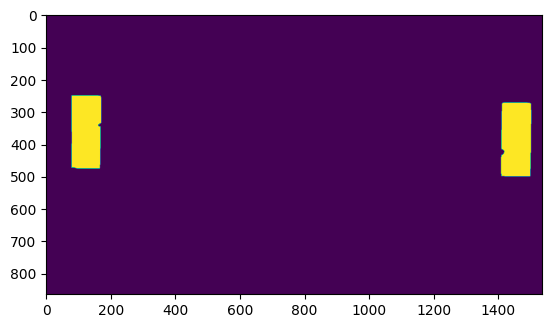

In [23]:
mask_goals_low = (75, 170, 9)
mask_goals_high = (116, 255, 158)

mask_ball_low = (23, 131, 133)  
mask_ball_high = (33, 251, 252)

video = cv2.VideoCapture(VIDEO_PATH)
video.set(cv2.CAP_PROP_POS_FRAMES, 15000)
ret, frame = video.read()

mask_goals = get_mask(frame, mask_goals_low, mask_goals_high)
mask_ball = get_mask(frame, mask_ball_low, mask_ball_high)
center_ball = get_biggest_contour_center(mask_ball)

if mask_goals(center_ball[1], center_ball[0]) == 255:
    print("ball is in goal")
        

plt.imshow(mask_goals)


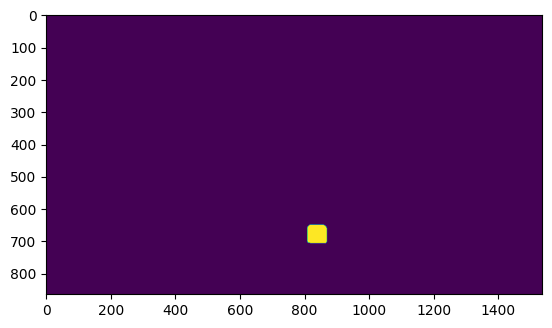

In [7]:
plt.imshow(mask_ball)